In [3]:
#Imports necesarios
import os
from dotenv import load_dotenv, find_dotenv
from polygon import RESTClient
import pandas as pd
from datetime import date
import statsmodels.api as sm
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt

In [4]:
# Cargar variables de entorno desde un archivo .env (recomendado para claves)
# Busca el archivo .env en la carpeta actual o en las carpetas padres
load_dotenv()

clave_fred = Fred(api_key=os.getenv("FRED_API_KEY"))
clave_polygon = os.getenv("POLYGON_API_KEY")


In [5]:
#Función que retorna los precios de cierre de una acción según su ticker y para un timeframe y frecuencia personalizada
        # DEFINIR PARÁMETROS DE BÚSQUEDA:
        # ticker, 
        # multiplier = Frecuencia: X de timeframe, 
        # timeframe = ('day', 'hour', 'minute', etc.), 
        # Fecha formato AAAA-MM-DD, 
        #      Fecha de hoy: to_date = date.today().strftime("%Y-%m-%d")
def precio_cierre(ticker, multiplier, timeframe, from_date, to_date):
    if not clave_polygon: #if not para verificar que la API_KEY es correcta
        print("ERROR: La clave de API no se ha cargado. Revisa tu archivo .env")
    else:
        # INICIALIZAR EL CLIENTE REST
        client = RESTClient(clave_polygon)
        # La función get_aggs devuelve un objeto iterable con los datos de las barras
        data_response = client.get_aggs(
            ticker=ticker,
            multiplier=multiplier,
            timespan=timeframe,
            from_=from_date,
            to=to_date, 
            sort="asc" # Ordenar por fecha ascendente
        )
    
    # 5. CONVERTIR LOS RESULTADOS A DATAFRAME (Pandas)
    # Primero, se convierte el objeto de respuesta a una lista de diccionarios
    data_list = [vars(agg) for agg in data_response]
    
    # Luego, se crea el DataFrame
    df = pd.DataFrame(data_list)
   
    # 6. LIMPIAR Y MOSTRAR DATOS
    # La columna 't' es el timestamp de Unix (hay que convertirlo a fecha legible)
    df['date'] = pd.to_datetime(df["timestamp"], unit="ms").dt.date
    
    # Seleccionar solo las columnas que nos interesan
    df = df[["close", "date"]]
    df.columns = ["close", "fecha"]
    return(df)


In [6]:
#Storage de los datos descargados
apple = precio_cierre("AAPL", 1, "day", "2024-11-22", "2025-11-22")
sp500 = precio_cierre("SPY", 1, "day", "2024-11-22", "2025-11-22")


In [7]:
#Cargo las TY10 de USA
DGS10_a = clave_fred.get_series('DGS10',"2024-11-22", "2025-11-22")  # 10-Year Treasury Constant Maturity Rate
DGS10_a = DGS10_a/100  # Convertir a decimal
DGS10_a = DGS10_a.dropna()
DGS10_a = DGS10_a.reset_index()
DGS10_a = DGS10_a.iloc[:,1].to_frame()
#paso la tasa anual a diaria

# Aplicar la fórmula de capitalización
DGS10 = (1 + DGS10_a)**(1/252) - 1

In [8]:
#Creamos las variables para nuestra regresion lineal
p_apple = apple['close']
p_sp500 = sp500['close']
r_apple = p_apple.pct_change().dropna().to_frame()
r_sp500 = p_sp500.pct_change().dropna().to_frame()

r_apple.reset_index(drop=True, inplace=True)
r_sp500.reset_index(drop=True, inplace=True)
DGS10.reset_index(drop=True, inplace=True)


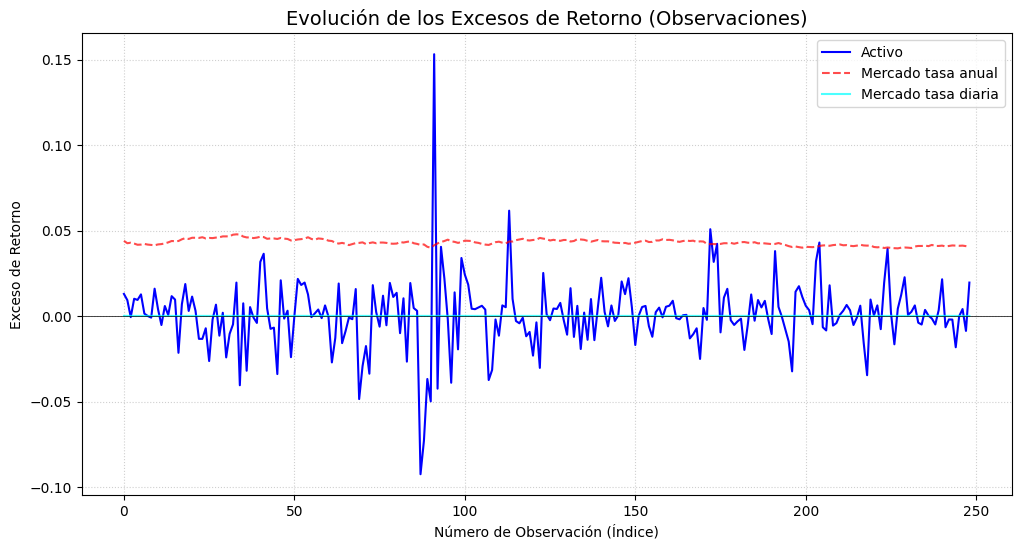

In [9]:
#Grafico de la tasa DGS10 anual y diario y retorno del activo


# Definir los nombres de las columnas
X_COL = 'Rm_Rf'  # Columna de Mercado (No se usa directamente como X, sino para comparar)
Y_COL = 'Ri_Rf'  # Columna de Activo

# 2. Creación del gráfico
plt.figure(figsize=(12, 6))
plt.title('Evolución de los Excesos de Retorno (Observaciones)', fontsize=14)

# Graficar ambas series de línea:
# Se usa df.index (los números 0, 1, 2...) como eje X automático
plt.plot(r_apple, label='Activo', color='blue', linewidth=1.5)
plt.plot(DGS10_a, label='Mercado tasa anual', color='red', linestyle='--', alpha=0.7)
plt.plot(DGS10, label='Mercado tasa diaria', color='cyan', alpha=0.7)

# 4. Etiquetas y Leyenda
plt.xlabel('Número de Observación (Índice)')
plt.ylabel('Exceso de Retorno')
plt.legend() # Muestra la leyenda para identificar las líneas

# Añadir línea de referencia en el origen (0)
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [14]:
# Exceso del mercado y del activo
# Antes es necesario que las columnas se llamen igual para hacer las restas
r_apple.columns = [""]
r_sp500.columns = [""]
DGS10.columns = [""]
prm = r_sp500 - DGS10

#Ahora calculamos el exceso del activo
pra = r_apple - DGS10



$$\mathbf{(R_i - R_f)} = \alpha_i + \beta_i \mathbf{(R_m - R_f)} + \varepsilon_i$$


In [11]:
#Creando el modelo simple de regresion lineal
c_prm = sm.add_constant(prm) # Agregar una constante (intercepto)
modelo = sm.OLS(pra, c_prm)
resultados = modelo.fit()
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                          R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     319.0
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           2.24e-46
Time:                        13:38:39   Log-Likelihood:                 717.14
No. Observations:                 249   AIC:                            -1430.
Df Residuals:                     247   BIC:                            -1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.367      0.714      -0.001       0.002
               1.2452      0.070     17.862      0.000       1.108       1.383
==============================================================================
Omnibus:                       16.888   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.610
Skew:                          -0.102   Prob(JB):                     1.69e-11
Kurtosis:                       5.177   Cond. No.                         80.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
r_sp500.columns = ['sp500']
r_apple.columns = ['apple']
data_1 = pd.merge(r_sp500, r_apple, left_index=True, right_index=True)
matriz_correlacion = data_1.corr()
print(matriz_correlacion)

          sp500     apple
sp500  1.000000  0.750743
apple  0.750743  1.000000


## Regresión lineal simple = Modelo de mercado, base CAPM

$\mathbf{(R_i - R_f)} = \alpha_i + \beta_i \mathbf{(R_m - R_f)} + \varepsilon_i$

#### Usé como variable dependiente el exceso de retorno del activo, así podemos quitar el riesgo no sistematico

Al usar apple y el sp500 lo esperado es primero que tengan una alta correlación, al usar como variable dependiente apple estoy preguntando sobre 